<a href="https://colab.research.google.com/github/adallak/FAST2022_ExplainableAI/blob/main/Session1_Model_Specific.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ConvNET Visualisation

We start by visualizing intermediate activations of the convnets. The goal is to visualize feature maps with three dimensions: width, height, and depth (channels). We will visualize feature maps by plotting the contents of every channel as a 2D image. 

For this purposes, I will use results from the pretrained simple model on the cat_vs_dogs datasets. 

In [ ]:
####################################
## Do not run
####################################
from tensorflow import keras 
from keras import layers

## Augment data
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

## Simple archtecture
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch.keras",
        save_best_only = True,
        monitor = "val_loss"
    )

]

history = model.fit(
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = callbacks
)

In [ ]:
!rm convnet_from_scratch*.keras

In [ ]:
## upload pretrained results
## Download from https://github.com/adallak/FAST2022_ExplainableAI/tree/main/data
from google.colab import files
uploaded = files.upload()

Saving convnet_from_scratch.keras to convnet_from_scratch.keras


In [ ]:
from tensorflow import keras 
import tensorflow as tf

model = keras.models.load_model(
    "convnet_from_scratch.keras"
)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

We will start with an easy example and then move to harder one.

## Import a new image

In [ ]:
## If you are using google colab, upload the image for prediction
#from google.colab import files
#uploaded = files.upload()

In [ ]:
from tensorflow import keras
import numpy as np
import os
img_path = keras.utils.get_file(
    fname="cutecat.jpg",
    origin = "https://raw.githubusercontent.com/adallak/FAST2022_ExplainableAI/main/data/cutecat.jpg")
img_path

647168/638682 [==============================] - 0s 0us/step


'/root/.keras/datasets/cutecat.jpg'

In [ ]:
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

The function `get_img_array`  converts image into an array using corresponding target_size

In [ ]:
preds = model.predict(img_tensor)
preds

array([[0.04091522]], dtype=float32)

## Display the picture

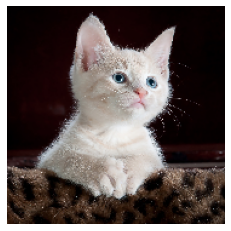

In [ ]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

## Instantiating a model that returns layer activations. Recall that the output of the layer is called activation.

In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)


When we fed an image as an input, the above model returns the layer activations as a list. 

Note that this is a multi-output model.

![](https://drive.google.com/uc?id=1SLzTJAUUpnp3HSQxU_brsUU9OcXPrzxP)

In [ ]:
print(len(layer_outputs))

9


## Using the model to compute layer activations

In [ ]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


In [ ]:
 ## Fint the strongest feature map
 imp_index = tf.argmax(tf.math.reduce_sum(first_layer_activation, axis = (1,2)),axis = 1)
 print(imp_index)

tf.Tensor([8], shape=(1,), dtype=int64)


## Visualizing the strongest channel

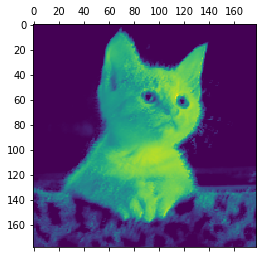

In [ ]:

import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, int(imp_index)], cmap="viridis")


## Visualizing every channel in every intermediate activation

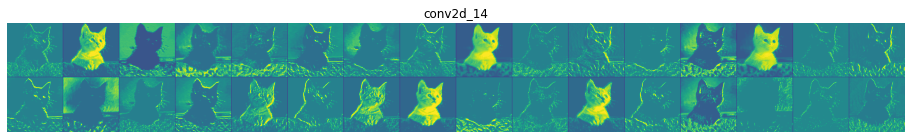

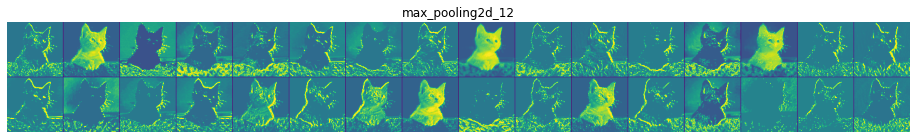

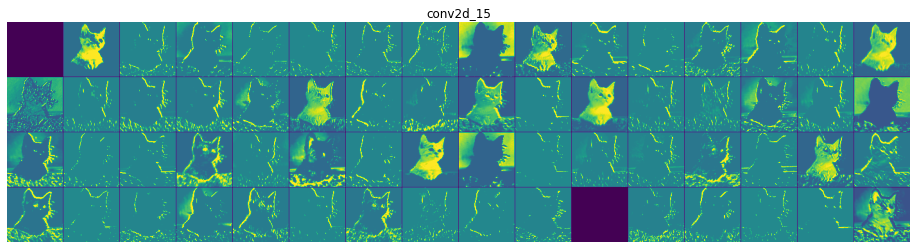

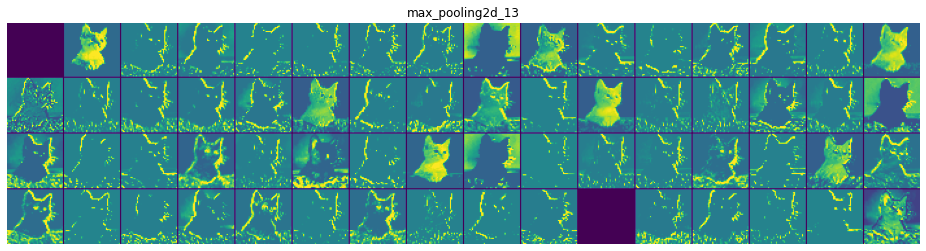

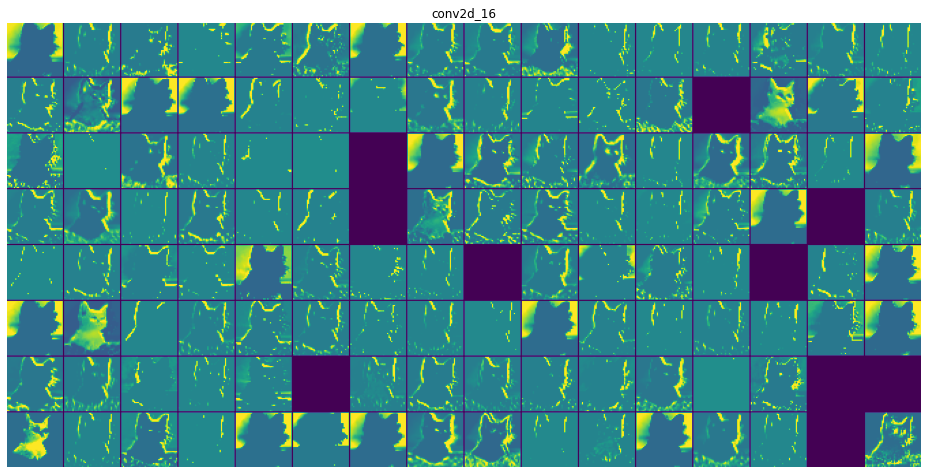

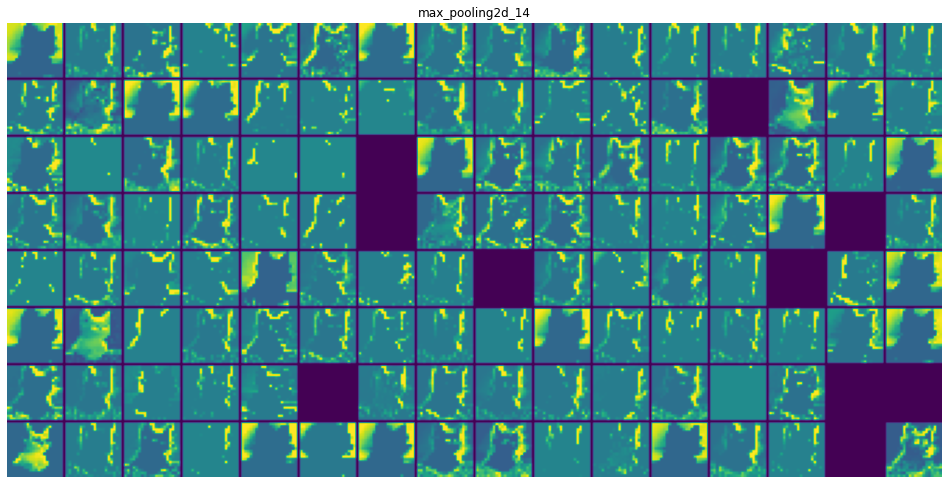

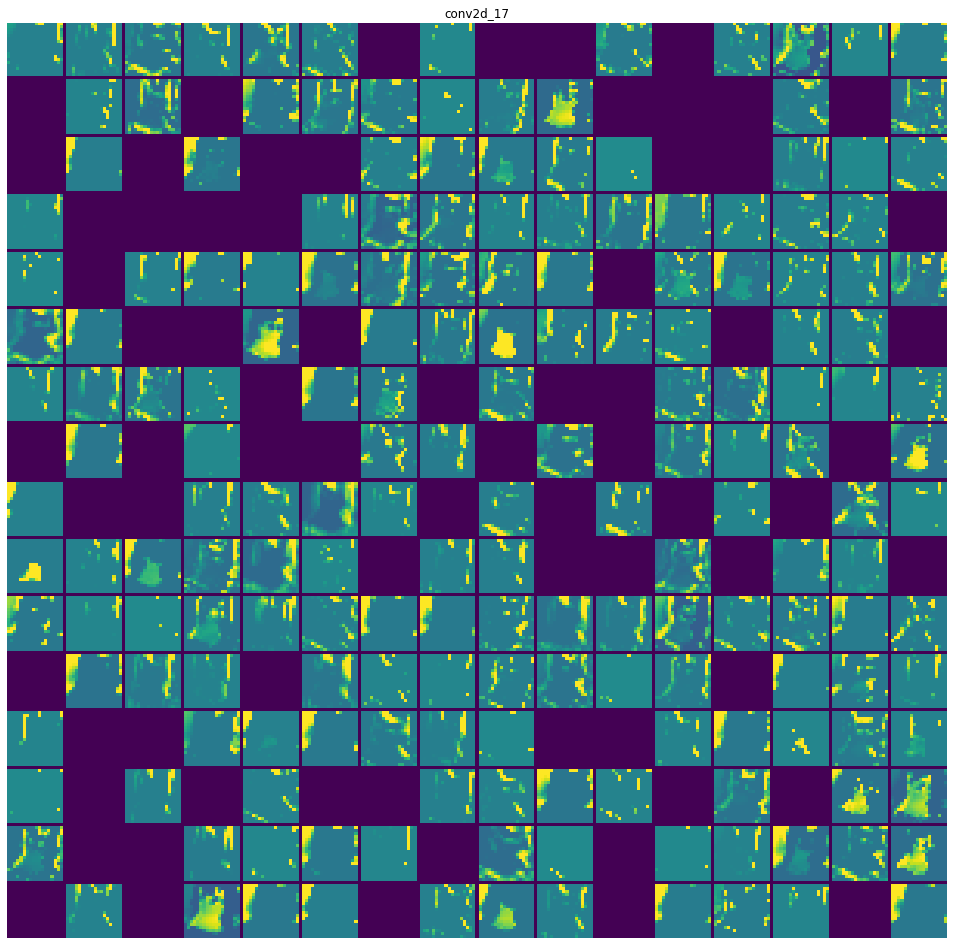

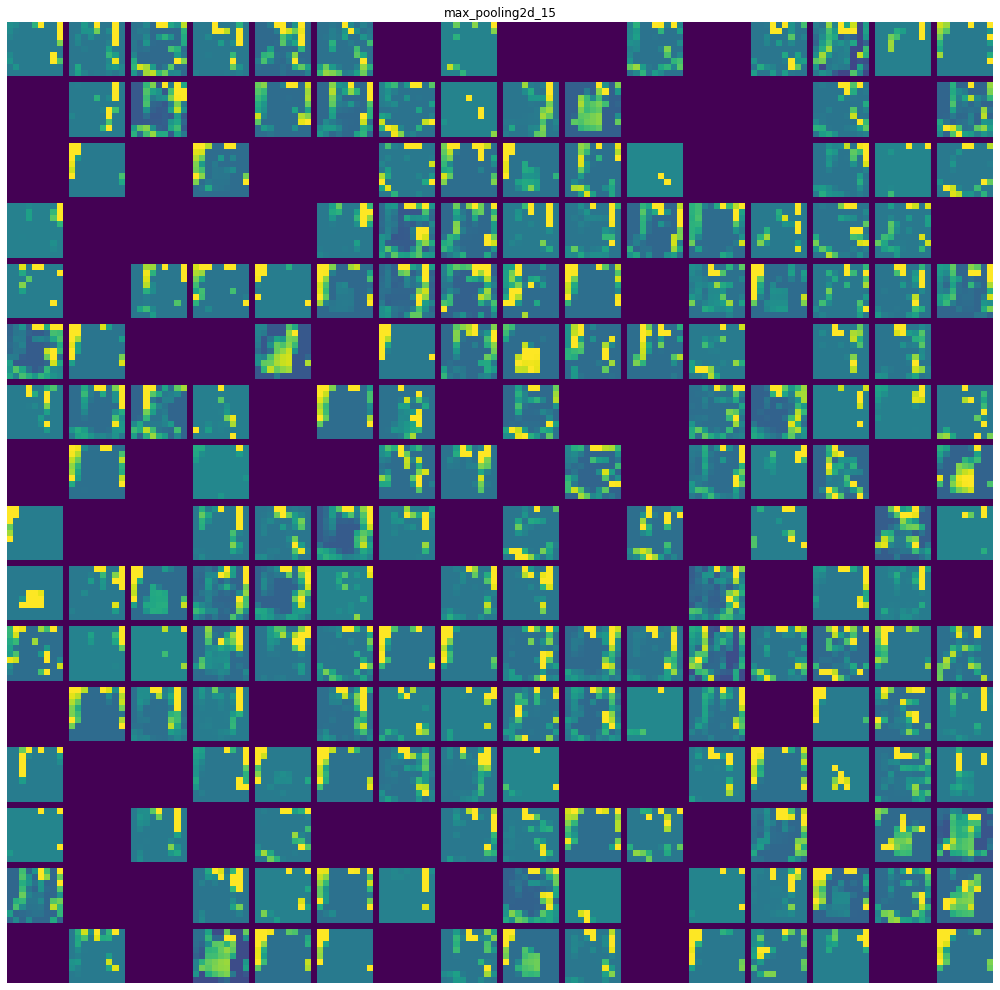

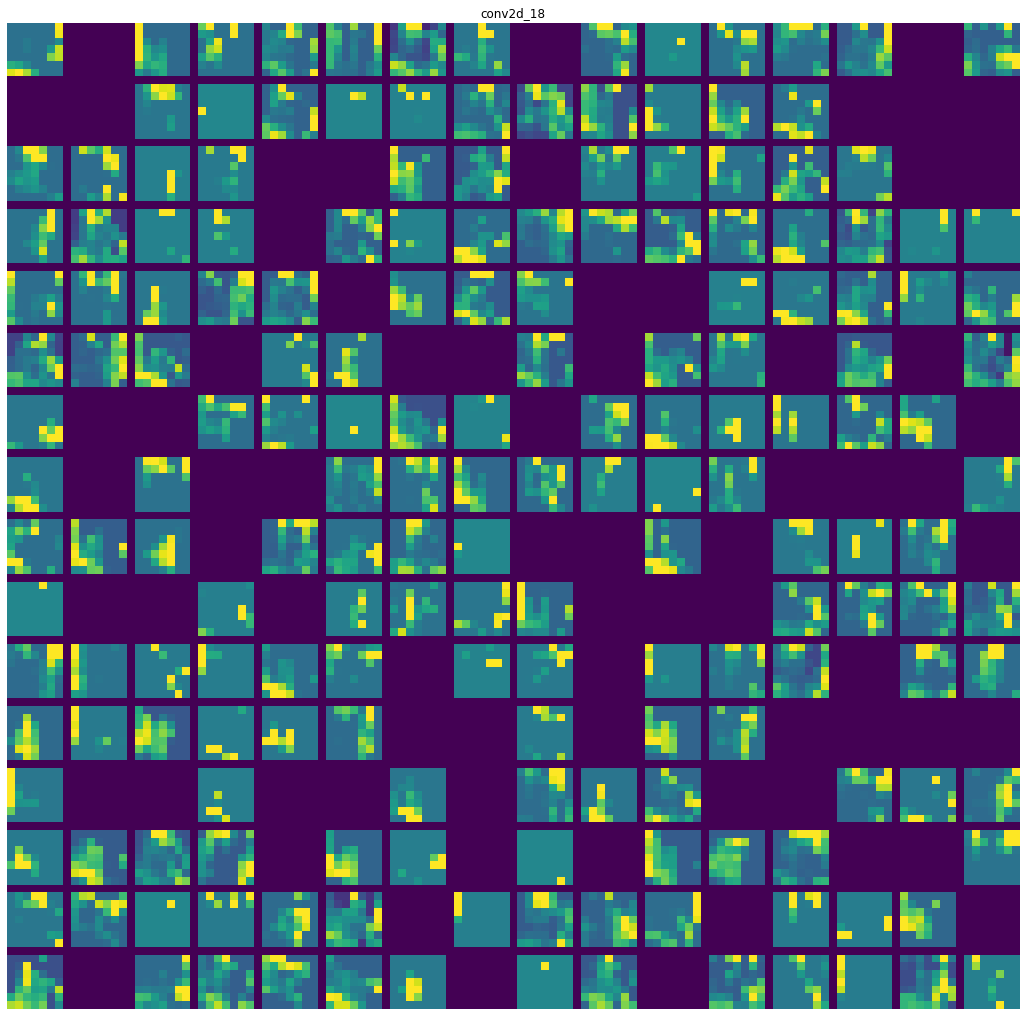

In [ ]:


images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### Visualize strongest feature map in each layer

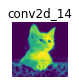

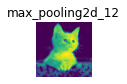

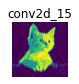

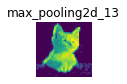

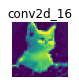

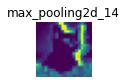

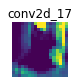

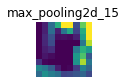

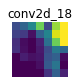

In [ ]:


images_per_row = 1
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    imp_feature = tf.argmax(tf.math.reduce_sum(layer_activation, axis = (1,2)),axis = 1)
    n_cols = 1  #//n_features // images_per_row
    display_grid = np.zeros((size,size))
    channel_image = layer_activation[0, :, :, int(imp_feature)].copy()
    if channel_image.sum() != 0:
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
    channel_image = np.clip(channel_image, 0, 255).astype("uint8")
    display_grid = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

What have we learned so far:

. The first layer acts as a collection of various edge detectors. The activations retain almost all of the information contained in the initial picture

. As we go deeper, the activations become more abstract and hard to intepret. The deeper layers contain less information about the input and more information related to the class of the image.

. The sparsity of the activations increases with the depth of the layer. This can be explained by the fact that the filter contains a pattern which isn'y found in the input image.

### Sensitivity analysis


You can occlude part of the input image and see how activations change

In [ ]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa
image_mask  = tfa.image.random_cutout(img_tensor, (90,90))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
activations = activation_model.predict(image_mask)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


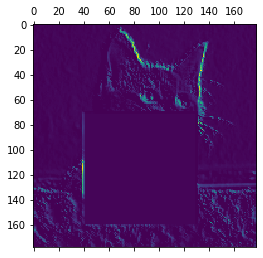

In [ ]:

import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 10], cmap="viridis")


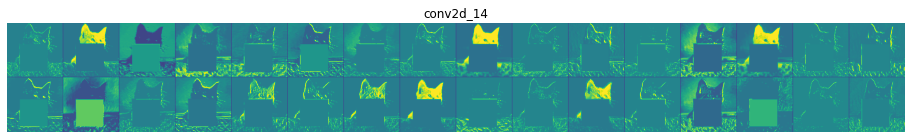

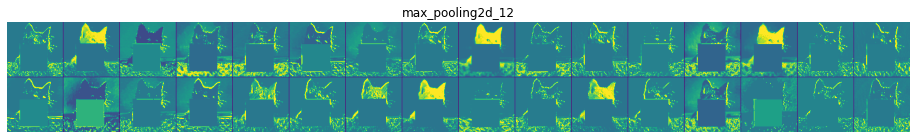

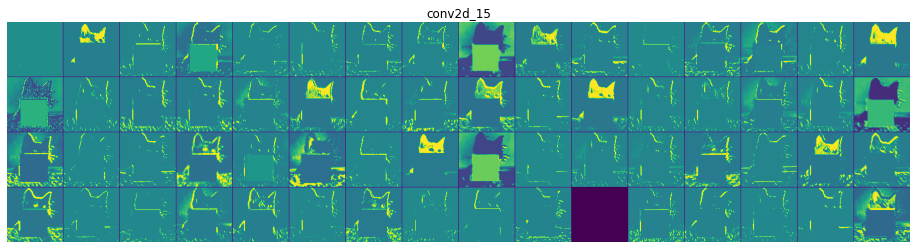

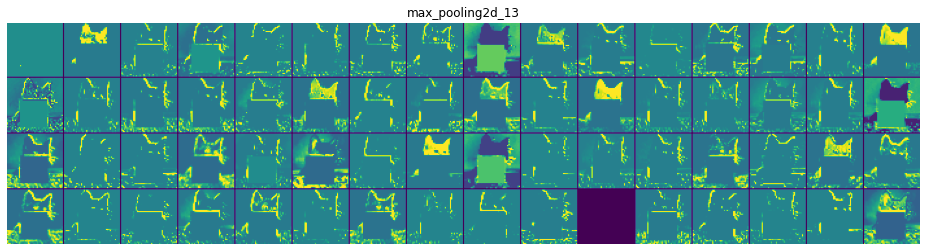

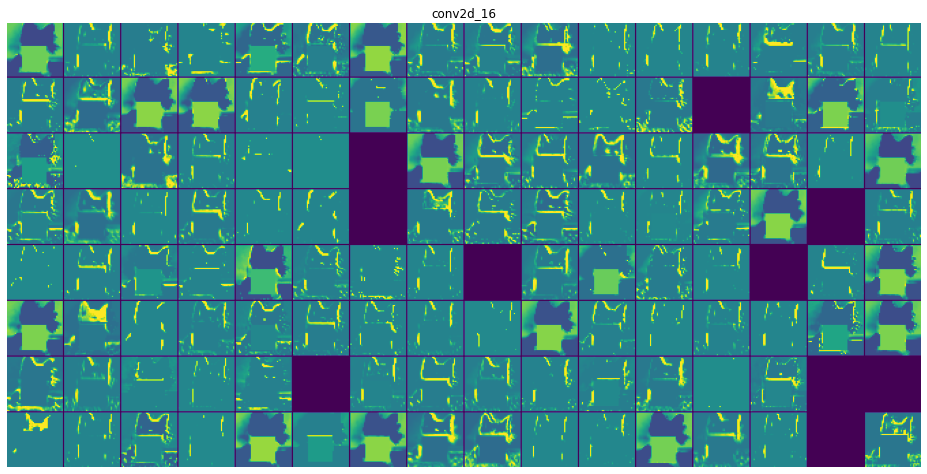

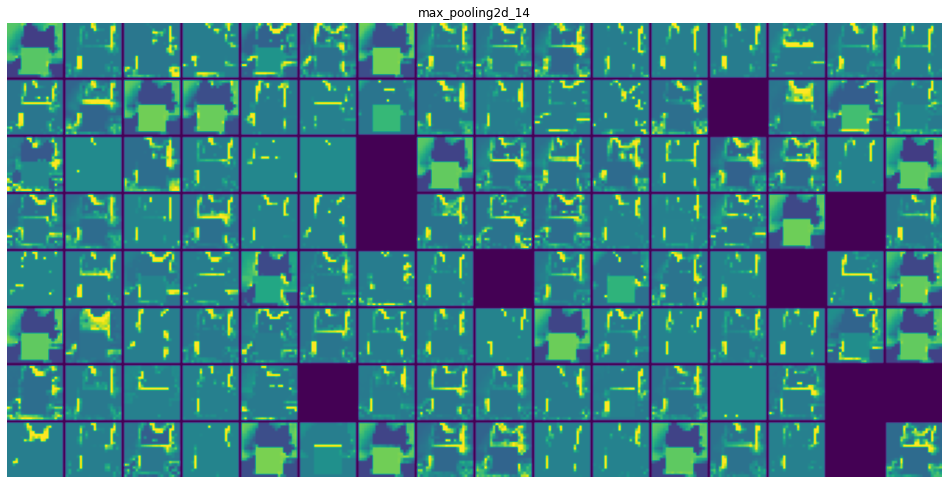

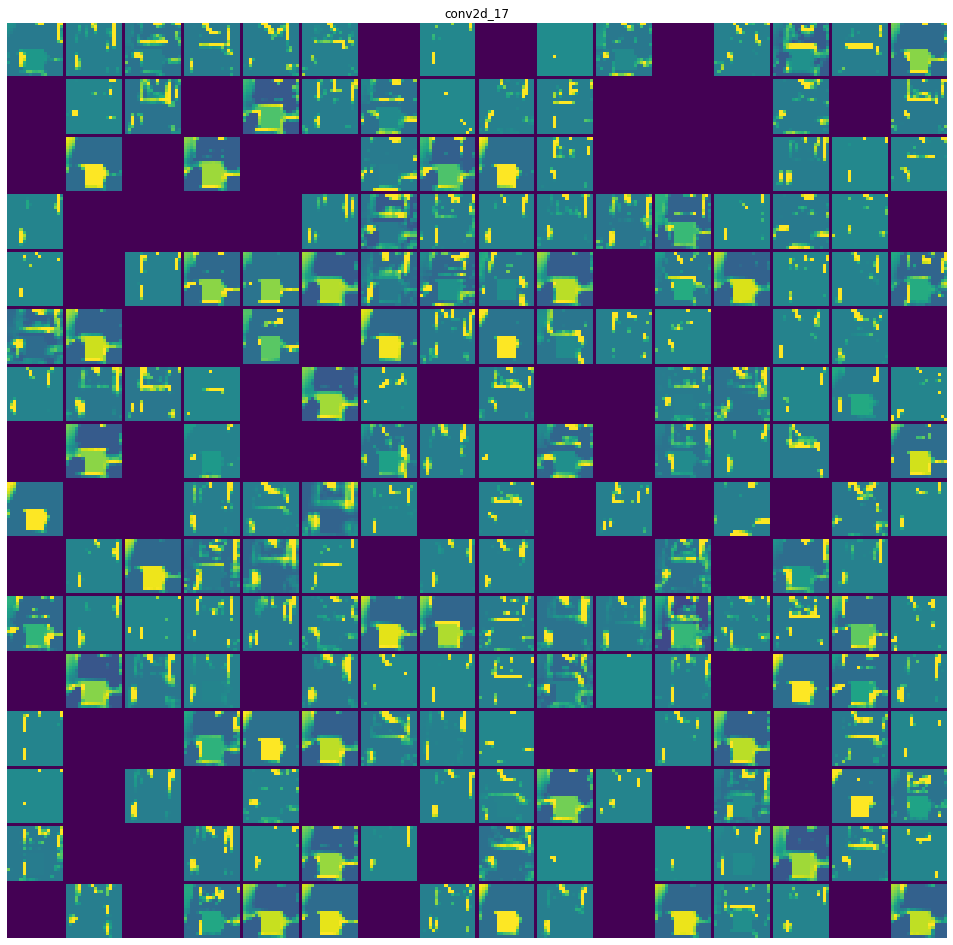

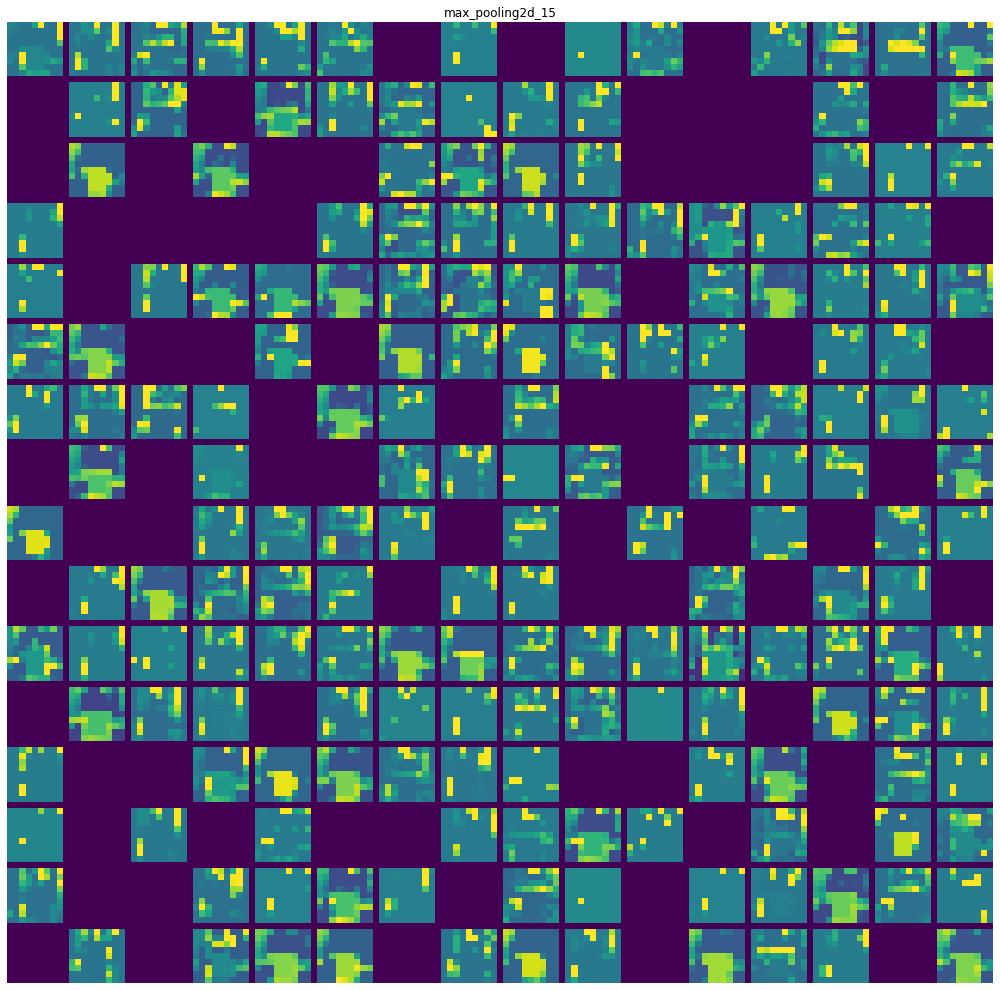

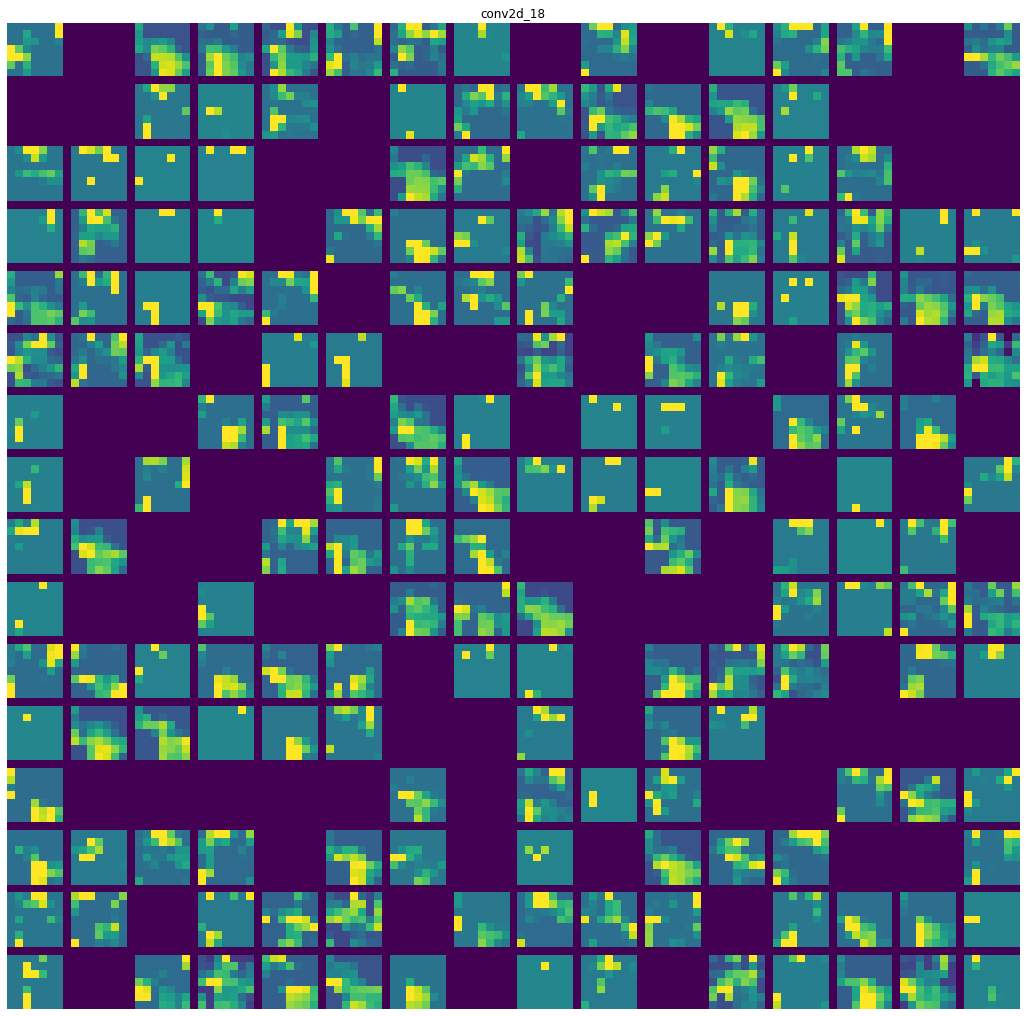

In [ ]:


images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

# Grad-CAM

In [ ]:
from tensorflow import keras
from keras import layers
import numpy as np

Here, we will use pretrained Xception model for the imagenet data.

In [ ]:
model = keras.applications.xception.Xception(weights = "imagenet")

91897856/91884032 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
## If you are using google colab, upload the image for prediction
#from google.colab import files
#uploaded = files.upload()

Saving Yellow-Lab-High-Five.jpg to Yellow-Lab-High-Five.jpg


In [ ]:
import numpy as np
import os
fullPath = os.path.abspath("./" + "Yellow-Lab-High-Five.jpg")
img_path = keras.utils.get_file(
    fname="Yellow-Lab-High-Five.jpg",
    origin = "https://raw.githubusercontent.com/adallak/FAST2022_ExplainableAI/main/data/Yellow-Lab-High-Five.jpg") #"file://" + fullPath)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

81920/68191 [====================================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


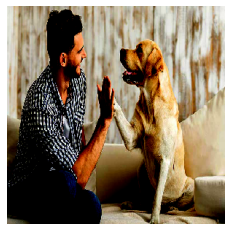

In [ ]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_array[0])
plt.show()

In [ ]:
preds = model.predict(img_array)

In [ ]:
print(keras.applications.xception.decode_predictions(preds, top = 3)[0])

49152/35363 [=========================================] - 0s 0us/step
[('n02099712', 'Labrador_retriever', 0.79988563), ('n02099601', 'golden_retriever', 0.048275884), ('n02088466', 'bloodhound', 0.013911711)]


## Guided Backpropagation

In [ ]:
import tensorflow as tf
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,tf.float32)  * tf.cast(x>0,tf.float32) * dy
    return tf.nn.relu(x), grad

The above function equates the negative gradients to 0.
Next, we substitute old activation function with the `guidedrelu`

In [ ]:
layer_dict = [layer for layer in model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu

Lets compute gradient of the top predicted class for our input image with respect to the input image.

*Note:* Since `img_tf` is not a tensor variable, we need to explicitly watch it. Recall that only Variables are automatically watched in a gradient tape. 

In [ ]:
img_tf = tf.convert_to_tensor(img_array)
with tf.GradientTape() as tape:
    tape.watch(img_tf)
    pred = model(img_tf)
    top_pred_index = tf.argmax(pred[0])
    top_class_channel = pred[:, top_pred_index]
guided_grad = tape.gradient(top_class_channel, img_tf)

Next function normalizes the gradient entries

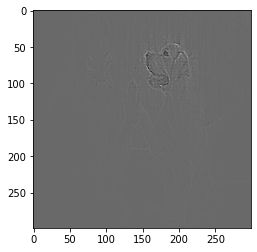

In [ ]:
def norm_flat_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm
plt.imshow(norm_flat_image(guided_grad[-1]), cmap = "gray")

## Implement Grad-CAM

`avg_pool` does global average pooling

In [ ]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

Select the last convoluation layer.

*Question:* Why are we interested in the last layer?

In [ ]:
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

We take the last layer as an input for our new model.

In [ ]:
classifier_input = keras.Input(shape = last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [ ]:
classifier_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 10, 2048)]    0         
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                                 
 predictions (Dense)         (None, 1000)              2049000   
                                                                 
Total params: 2,049,000
Trainable params: 2,049,000
Non-trainable params: 0
_________________________________________________________________


Now, we compute the gradient of the top predicted class for our input image with respect to the activations of the last convolution layer.

*Question:* Why do we need to explicitly watch the gradient?

In [ ]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [ ]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
## This vector contains the mean intensity of the gradient for a given channel.
pooled_grads = tf.reduce_mean(grads, axis = (0,1,2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
## Multiply wach channel in the output of the last convolutional layer
## by how important this channel is
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis = -1)

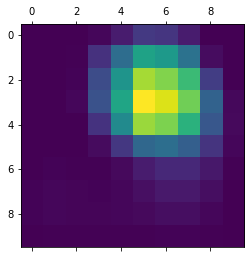

In [ ]:
## Class avtivation hitmap
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Lets superimpose the original image on the heatmap

In [ ]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:,:3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.6 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "labrador_cam.jpg"
superimposed_img.save(save_path)

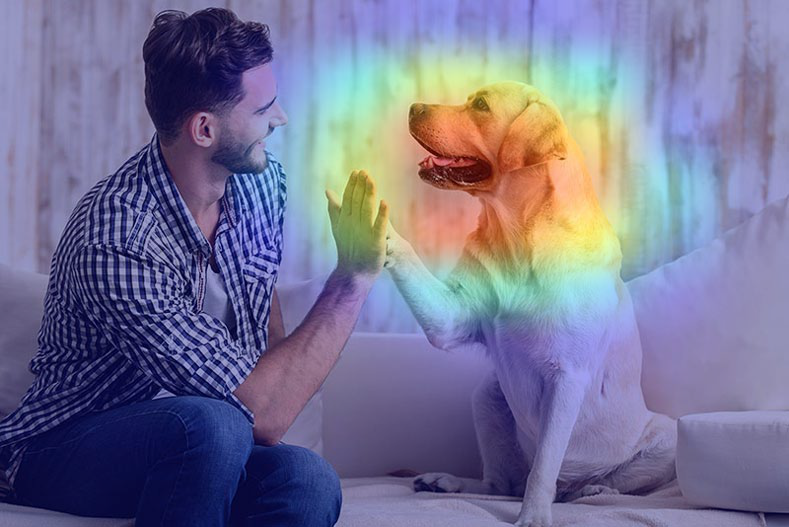

In [ ]:
superimposed_img

The above visualization answers two questions:

    . Why did the network think this image contained a labrador.
    . Where is the labrador located in the picture.

## Guide-CAM: Add guided backpropagation for better interpratation

In [ ]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:,:3]
jet_heatmap = jet_colors[heatmap]
cam_heatmap = keras.utils.array_to_img(jet_heatmap)
cam_heatmap = cam_heatmap.resize((299, 299))
cam_heatmap = keras.utils.img_to_array(cam_heatmap)

In [ ]:
guided_CAM = tf.math.multiply(norm_flat_image(guided_grad[-1]), norm_flat_image(cam_heatmap))

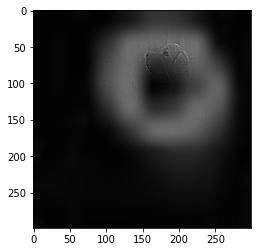

In [ ]:
plt.imshow(guided_CAM, cmap = "gray")

*NOTE:* Why did the network predicted labrador retriever instead of golden retriever?

I am not an expert in dogs, but one difference is in snouts, which guided_CAM captures.